# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


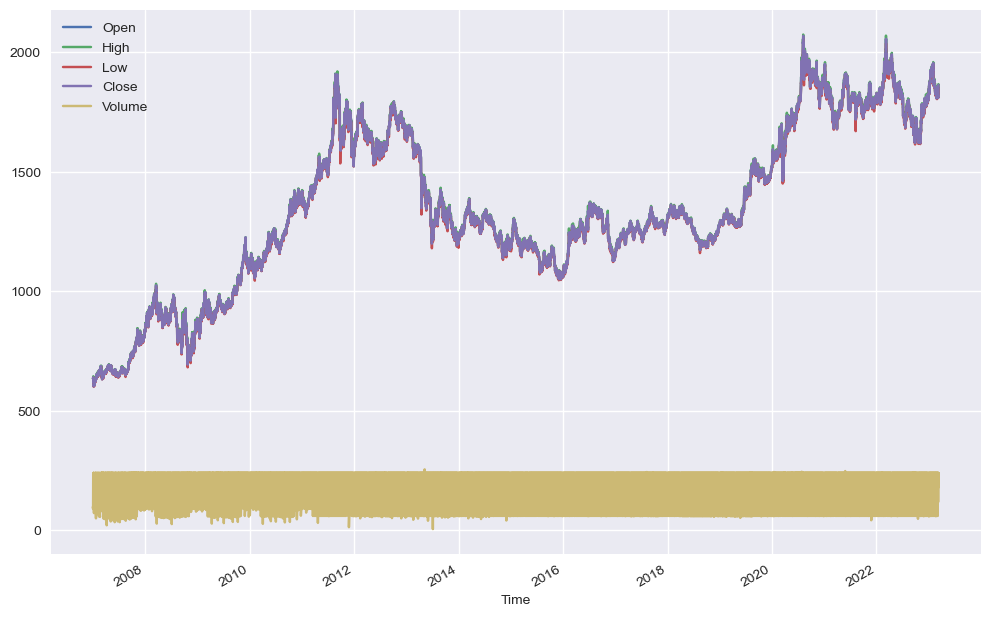

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            if self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [10]:
strategy = Linear_Regression
account_size = 200000
folder_ML_Strategy = 'Linear Regression'

In [15]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=1):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data.dropna(inplace=True)
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(365)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=1):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=20000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        filename_train = f'result_{self.TF}_In_Sample.csv'
        filepath_train = f'../../out/Machine_Learning/Multiple_Linear_Regression/Backtest/train.csv'
        # self.Save_Result(result_train, filepath_train)


        self.Predict()
        result_test = self.Backtest(self.data_test)
        filename_test = f'result_{self.TF}_Out_Sample.csv'
        filepath_test = f'../../out/Machine_Learning/Multiple_Linear_Regression/Backtest/test.csv'
        # self.Save_Result(result_test, filepath_test)

        return result_train, result_test

## TF D1

In [16]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [17]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [18]:
train , test = ml.Run()

### In-Sample Backtesting

In [19]:
train

Start                     2008-03-03 00:00:00
End                       2020-12-31 00:00:00
Duration                   4686 days 00:00:00
Exposure Time [%]                   99.949975
Equity Final [$]                    20874.081
Equity Peak [$]                     21048.181
Return [%]                           4.370405
Buy & Hold Return [%]               92.483589
Return (Ann.) [%]                    0.269987
Volatility (Ann.) [%]                1.029978
Sharpe Ratio                         0.262129
Sortino Ratio                        0.357886
Calmar Ratio                         0.065819
Max. Drawdown [%]                    -4.10195
Avg. Drawdown [%]                   -0.288661
Max. Drawdown Duration     3262 days 00:00:00
Avg. Drawdown Duration      113 days 00:00:00
# Trades                                   13
Win Rate [%]                        38.461538
Best Trade [%]                      64.012258
Worst Trade [%]                     -4.957543
Avg. Trade [%]                    

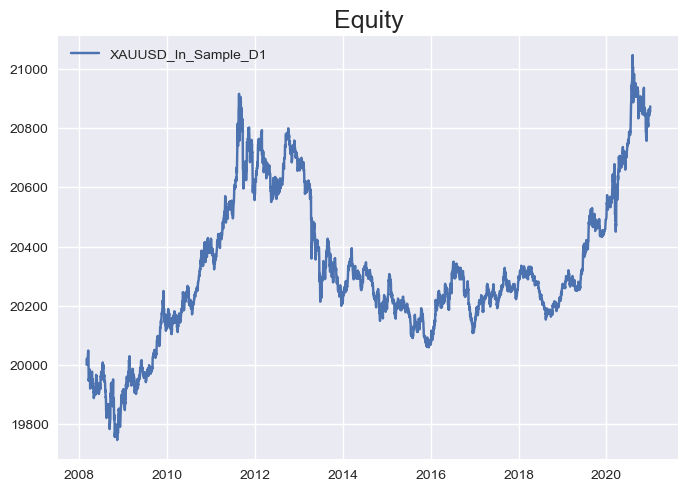

In [20]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [21]:
test

Start                     2020-01-03 00:00:00
End                       2023-03-10 00:00:00
Duration                   1162 days 00:00:00
Exposure Time [%]                   99.797776
Equity Final [$]                    20302.297
Equity Peak [$]                     20540.047
Return [%]                           1.511485
Buy & Hold Return [%]               20.146953
Return (Ann.) [%]                    0.382981
Volatility (Ann.) [%]                1.309736
Sharpe Ratio                         0.292411
Sortino Ratio                        0.396645
Calmar Ratio                         0.177833
Max. Drawdown [%]                   -2.153598
Avg. Drawdown [%]                   -0.307261
Max. Drawdown Duration      946 days 00:00:00
Avg. Drawdown Duration       67 days 00:00:00
# Trades                                    3
Win Rate [%]                            100.0
Best Trade [%]                      13.746368
Worst Trade [%]                      1.227344
Avg. Trade [%]                    

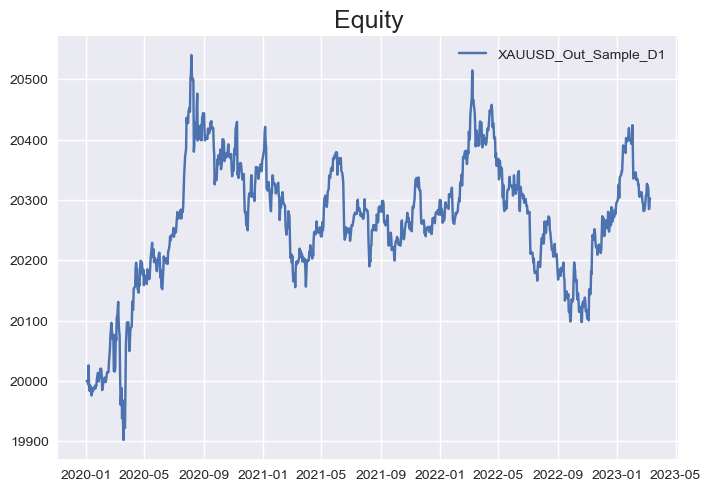

In [22]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [19]:
filename_train = f'result_{TF}_In_Sample.csv'

In [20]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [21]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [22]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [23]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [24]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [25]:
train , test = ml.Run()

### In-Sample Backtesting

In [26]:
train

Start                     2007-03-23 04:00:00
End                       2020-12-31 20:00:00
Duration                   5032 days 16:00:00
Exposure Time [%]                   99.990954
Equity Final [$]                    21232.944
Equity Peak [$]                     21405.404
Return [%]                            6.16472
Buy & Hold Return [%]              186.997465
Return (Ann.) [%]                    0.353317
Volatility (Ann.) [%]                0.992872
Sharpe Ratio                         0.355853
Sortino Ratio                         0.48799
Calmar Ratio                         0.087187
Max. Drawdown [%]                   -4.052382
Avg. Drawdown [%]                   -0.103629
Max. Drawdown Duration     3261 days 00:00:00
Avg. Drawdown Duration       28 days 10:00:00
# Trades                                   13
Win Rate [%]                        61.538462
Best Trade [%]                      43.372731
Worst Trade [%]                     -0.465191
Avg. Trade [%]                    

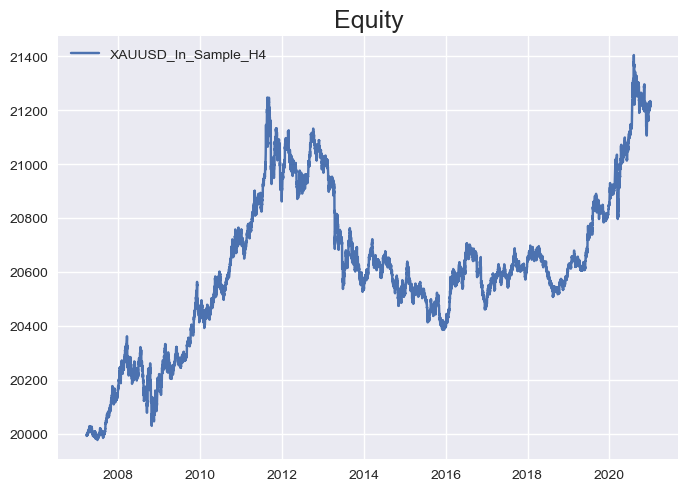

In [27]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [28]:
test

Start                     2020-01-02 04:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.960807
Equity Final [$]                     20341.03
Equity Peak [$]                     20547.223
Return [%]                            1.70515
Buy & Hold Return [%]               22.708422
Return (Ann.) [%]                    0.422651
Volatility (Ann.) [%]                1.313073
Sharpe Ratio                         0.321879
Sortino Ratio                        0.437634
Calmar Ratio                         0.193195
Max. Drawdown [%]                   -2.187697
Avg. Drawdown [%]                   -0.155402
Max. Drawdown Duration      945 days 20:00:00
Avg. Drawdown Duration       27 days 11:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      22.407364
Worst Trade [%]                     22.407364
Avg. Trade [%]                    

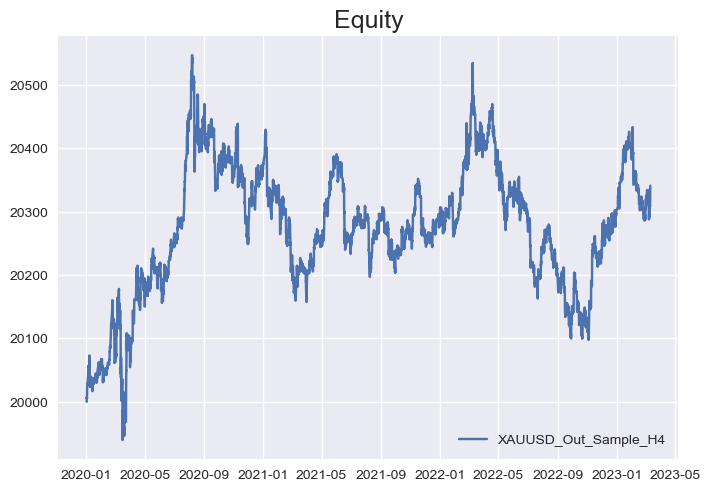

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [30]:
filename_train = f'result_{TF}_In_Sample.csv'

In [31]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [32]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [33]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [34]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [35]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [36]:
train , test = ml.Run()

### In-Sample Backtesting

In [37]:
train

Start                     2007-01-01 02:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 19:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                    21089.026
Equity Peak [$]                     21261.293
Return [%]                            5.44513
Buy & Hold Return [%]              198.348973
Return (Ann.) [%]                    0.306461
Volatility (Ann.) [%]                0.972126
Sharpe Ratio                         0.315249
Sortino Ratio                        0.431817
Calmar Ratio                         0.056138
Max. Drawdown [%]                   -5.459061
Avg. Drawdown [%]                   -0.070593
Max. Drawdown Duration     3335 days 22:00:00
Avg. Drawdown Duration       14 days 13:00:00
# Trades                                 3475
Win Rate [%]                        54.935252
Best Trade [%]                       7.008369
Worst Trade [%]                    -11.105848
Avg. Trade [%]                    

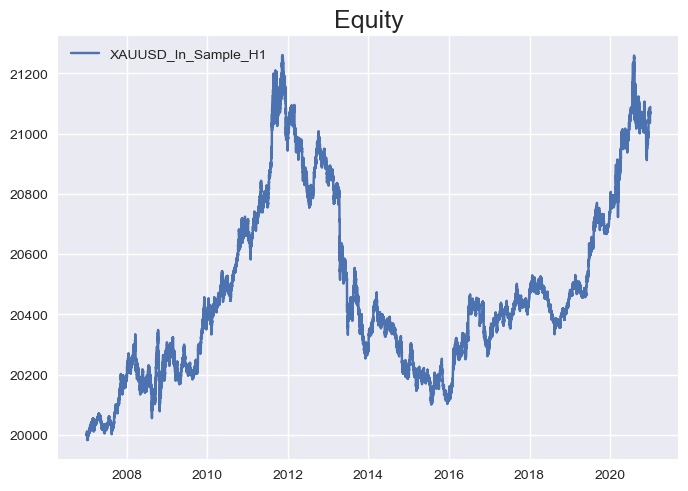

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-02 01:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.989396
Equity Final [$]                    20139.204
Equity Peak [$]                     20520.059
Return [%]                            0.69602
Buy & Hold Return [%]               22.689281
Return (Ann.) [%]                    0.166293
Volatility (Ann.) [%]                1.303844
Sharpe Ratio                         0.127541
Sortino Ratio                        0.172008
Calmar Ratio                         0.058015
Max. Drawdown [%]                   -2.866386
Avg. Drawdown [%]                   -0.099035
Max. Drawdown Duration      945 days 19:00:00
Avg. Drawdown Duration       13 days 15:00:00
# Trades                                  633
Win Rate [%]                        52.290679
Best Trade [%]                       3.992523
Worst Trade [%]                     -6.187112
Avg. Trade [%]                    

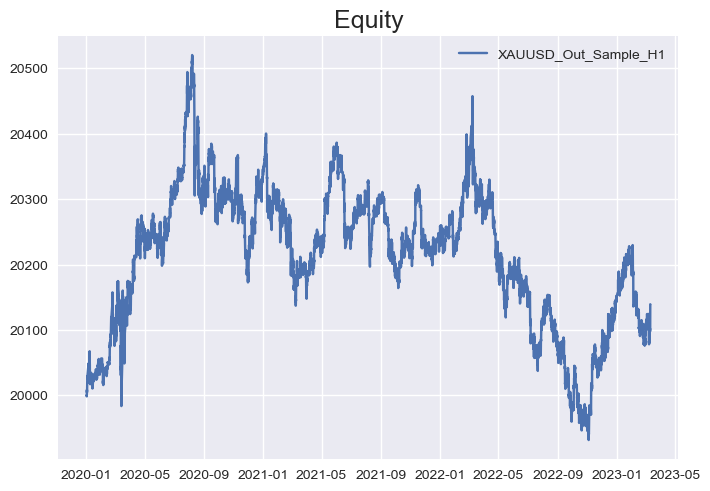

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [45]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [46]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [47]:
train , test = ml.Run()

### In-Sample Backtesting

In [48]:
train

Start                     2007-01-01 01:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 20:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                    22102.644
Equity Peak [$]                      22394.07
Return [%]                           10.51322
Buy & Hold Return [%]              198.465809
Return (Ann.) [%]                    0.579369
Volatility (Ann.) [%]                0.931185
Sharpe Ratio                         0.622184
Sortino Ratio                        0.891714
Calmar Ratio                         0.272455
Max. Drawdown [%]                   -2.126479
Avg. Drawdown [%]                   -0.047467
Max. Drawdown Duration     2523 days 11:30:00
Avg. Drawdown Duration        6 days 11:10:00
# Trades                                49820
Win Rate [%]                        54.132878
Best Trade [%]                       4.383939
Worst Trade [%]                     -5.755643
Avg. Trade [%]                    

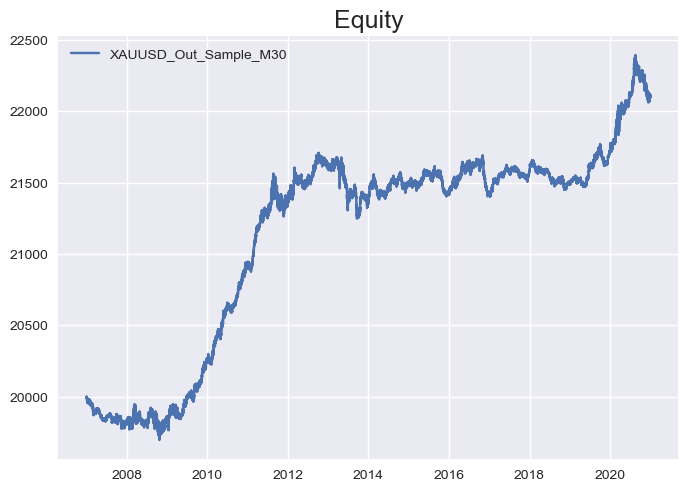

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 17:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                    20692.277
Equity Peak [$]                     20702.225
Return [%]                           3.461385
Buy & Hold Return [%]               22.702203
Return (Ann.) [%]                    0.848984
Volatility (Ann.) [%]                1.278715
Sharpe Ratio                         0.663935
Sortino Ratio                          0.9385
Calmar Ratio                         0.391819
Max. Drawdown [%]                   -2.166778
Avg. Drawdown [%]                   -0.076133
Max. Drawdown Duration      564 days 09:30:00
Avg. Drawdown Duration        6 days 17:54:00
# Trades                                11589
Win Rate [%]                        54.439555
Best Trade [%]                       1.915367
Worst Trade [%]                     -4.848957
Avg. Trade [%]                    

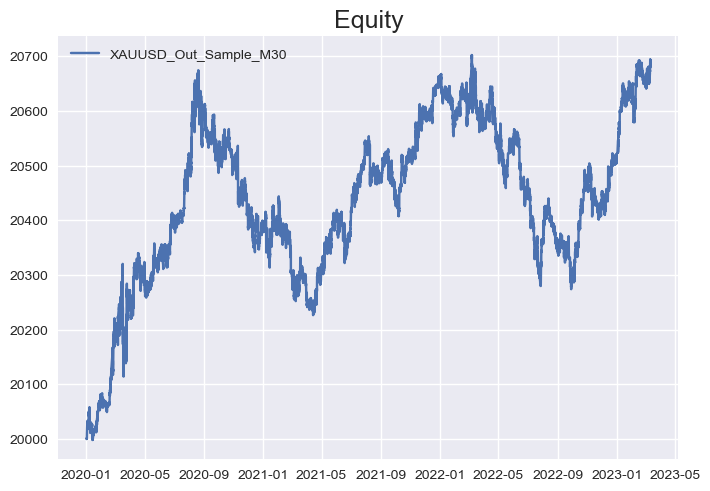

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [56]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [57]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [58]:
train , test = ml.Run()

### In-Sample Backtesting

In [59]:
train

Start                     2014-09-23 13:30:00
End                       2020-12-31 21:45:00
Duration                   2291 days 08:15:00
Exposure Time [%]                   99.998651
Equity Final [$]                    20560.879
Equity Peak [$]                     21060.244
Return [%]                           2.804395
Buy & Hold Return [%]               54.859418
Return (Ann.) [%]                    0.355712
Volatility (Ann.) [%]                0.872501
Sharpe Ratio                         0.407692
Sortino Ratio                        0.573376
Calmar Ratio                          0.13183
Max. Drawdown [%]                   -2.698274
Avg. Drawdown [%]                   -0.041205
Max. Drawdown Duration     1343 days 09:00:00
Avg. Drawdown Duration        4 days 12:57:00
# Trades                                73215
Win Rate [%]                        52.399099
Best Trade [%]                       2.433492
Worst Trade [%]                     -2.940285
Avg. Trade [%]                    

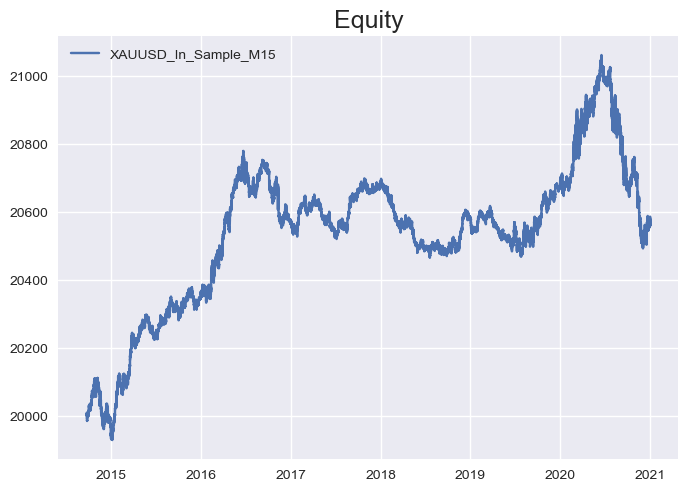

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-01 23:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                    20246.897
Equity Peak [$]                     20365.995
Return [%]                           1.234485
Buy & Hold Return [%]               22.692269
Return (Ann.) [%]                    0.312481
Volatility (Ann.) [%]                1.364428
Sharpe Ratio                          0.22902
Sortino Ratio                        0.308499
Calmar Ratio                          0.11199
Max. Drawdown [%]                   -2.790254
Avg. Drawdown [%]                   -0.069646
Max. Drawdown Duration      997 days 05:45:00
Avg. Drawdown Duration        9 days 08:36:00
# Trades                                37502
Win Rate [%]                        52.253213
Best Trade [%]                       2.056397
Worst Trade [%]                     -2.894386
Avg. Trade [%]                    

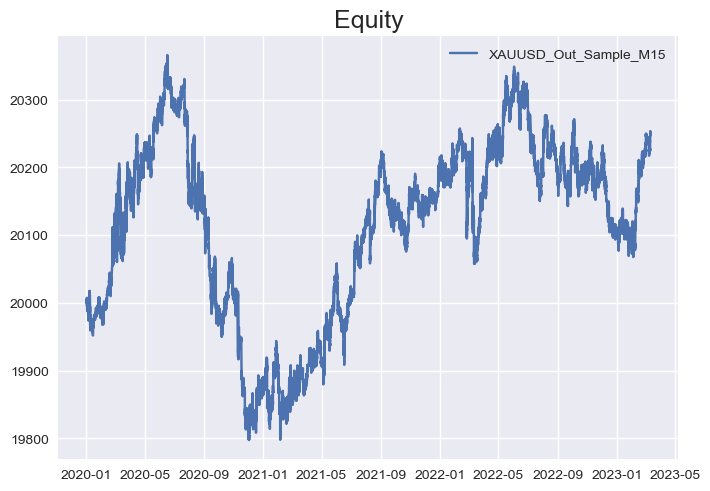

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [65]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [66]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [67]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [68]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [69]:
train , test = ml.Run()

### In-Sample Backtesting

In [70]:
train

Start                     2020-05-15 11:20:00
End                       2023-03-10 17:55:00
Duration                   1029 days 06:35:00
Exposure Time [%]                      99.999
Equity Final [$]                    20855.075
Equity Peak [$]                     20946.361
Return [%]                           4.275375
Buy & Hold Return [%]                7.465707
Return (Ann.) [%]                    1.249298
Volatility (Ann.) [%]                1.194756
Sharpe Ratio                         1.045651
Sortino Ratio                        1.501818
Calmar Ratio                         0.914662
Max. Drawdown [%]                   -1.365857
Avg. Drawdown [%]                   -0.029163
Max. Drawdown Duration      345 days 04:20:00
Avg. Drawdown Duration        1 days 10:36:00
# Trades                               103142
Win Rate [%]                        52.109713
Best Trade [%]                       1.008559
Worst Trade [%]                     -3.754972
Avg. Trade [%]                    

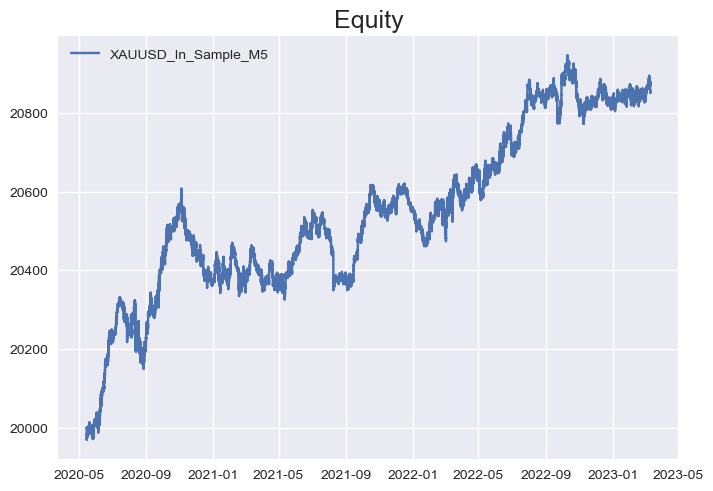

In [71]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [72]:
test

Start                     2023-01-02 23:10:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:45:00
Exposure Time [%]                   99.985068
Equity Final [$]                    20012.548
Equity Peak [$]                     20051.502
Return [%]                            0.06274
Buy & Hold Return [%]                2.074288
Return (Ann.) [%]                    0.219848
Volatility (Ann.) [%]                0.856575
Sharpe Ratio                          0.25666
Sortino Ratio                        0.350617
Calmar Ratio                         0.785241
Max. Drawdown [%]                   -0.279976
Avg. Drawdown [%]                   -0.030465
Max. Drawdown Duration       33 days 01:55:00
Avg. Drawdown Duration        1 days 04:34:00
# Trades                                 6913
Win Rate [%]                        52.292782
Best Trade [%]                       0.412583
Worst Trade [%]                     -1.464118
Avg. Trade [%]                    

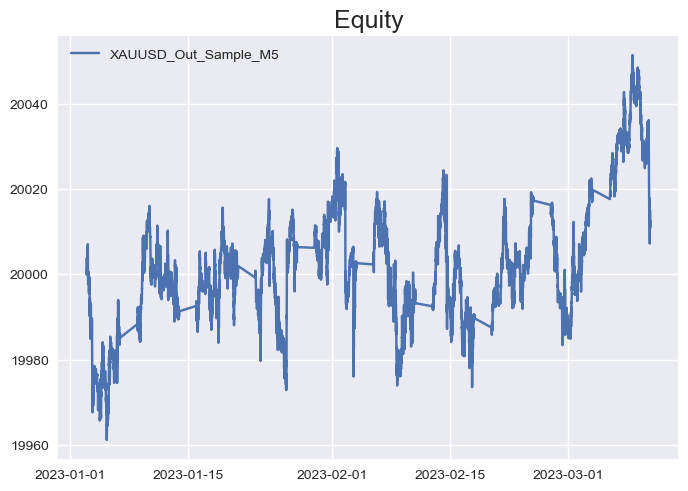

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [74]:
filename_train = f'result_{TF}_In_Sample.csv'

In [75]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [76]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [77]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [78]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [79]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [80]:
train , test = ml.Run()

### In-Sample Backtesting

In [81]:
train

Start                     2022-08-16 23:15:00
End                       2023-03-10 17:59:00
Duration                    205 days 18:44:00
Exposure Time [%]                      99.999
Equity Final [$]                    20620.104
Equity Peak [$]                      20638.81
Return [%]                            3.10052
Buy & Hold Return [%]                4.981871
Return (Ann.) [%]                    4.461643
Volatility (Ann.) [%]                1.276871
Sharpe Ratio                         3.494199
Sortino Ratio                        6.306656
Calmar Ratio                         7.481773
Max. Drawdown [%]                   -0.596335
Avg. Drawdown [%]                   -0.010785
Max. Drawdown Duration       46 days 10:01:00
Avg. Drawdown Duration        0 days 05:19:00
# Trades                                99263
Win Rate [%]                        52.148333
Best Trade [%]                       0.988492
Worst Trade [%]                      -0.80553
Avg. Trade [%]                    

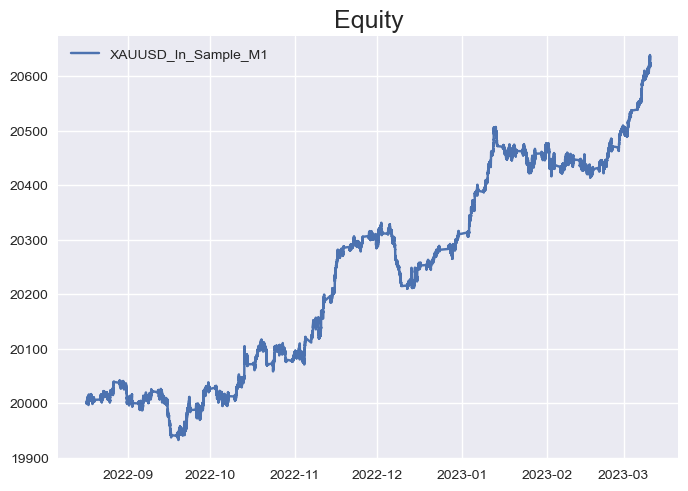

In [82]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [83]:
test

Start                     2023-01-02 23:02:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:57:00
Exposure Time [%]                   99.997013
Equity Final [$]                    20306.258
Equity Peak [$]                     20324.964
Return [%]                            1.53129
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                     6.80421
Volatility (Ann.) [%]                1.355598
Sharpe Ratio                         5.019341
Sortino Ratio                       10.227804
Calmar Ratio                        14.731321
Max. Drawdown [%]                   -0.461887
Avg. Drawdown [%]                   -0.008543
Max. Drawdown Duration       46 days 10:01:00
Avg. Drawdown Duration        0 days 03:22:00
# Trades                                33296
Win Rate [%]                        52.763095
Best Trade [%]                       0.673684
Worst Trade [%]                     -0.644081
Avg. Trade [%]                    

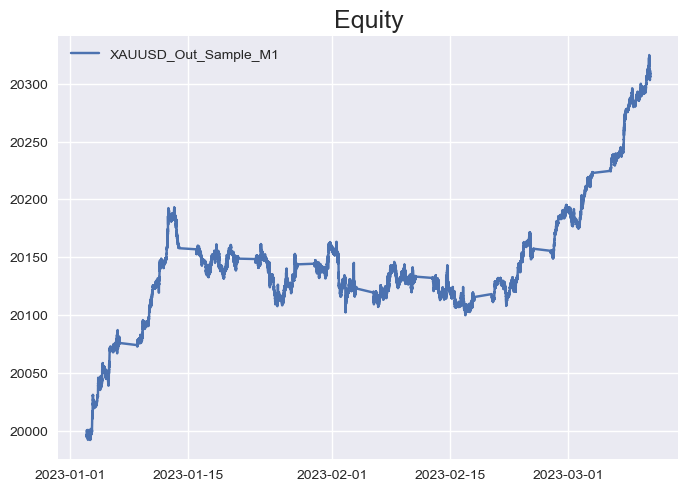

In [84]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [85]:
filename_train = f'result_{TF}_In_Sample.csv'

In [86]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [87]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [88]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')